In [51]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

In [2]:
#Loading the dataset, there are two dataset, the train and test dataset
df=pd.read_excel('airlinetrain.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3898
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7663
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13883
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6219
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13303


In [3]:
#loading the test dataset
df2=pd.read_excel('airlinetest.xlsx')
df2.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [4]:
#we want to work with our training dataset, we want to get patterns, so before that, we can get informations about our data
#and also our columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


From the information from the table, we can see that we have to convert Date_of_Journey, Dep_Time, Arrival_Time and Duration columns to datetime....

In [5]:
df['Dep_Time']=pd.to_datetime(df['Dep_Time'])
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
df['Arrival_Time']=pd.to_datetime(df['Arrival_Time'])

In [6]:
# we can't convert Duration column to datetime cos the number of nanoseconds would be exceeded, so we use errors='coerce'
df['Duration']=pd.to_datetime(df['Duration'],errors = 'coerce')

Let's check our columns if the right data types are attributed to each column

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Airline          10683 non-null  object        
 1   Date_of_Journey  10683 non-null  datetime64[ns]
 2   Source           10683 non-null  object        
 3   Destination      10683 non-null  object        
 4   Route            10682 non-null  object        
 5   Dep_Time         10683 non-null  datetime64[ns]
 6   Arrival_Time     10683 non-null  datetime64[ns]
 7   Duration         0 non-null      datetime64[ns]
 8   Total_Stops      10682 non-null  object        
 9   Additional Info  10683 non-null  object        
 10  Price            10683 non-null  int64         
dtypes: datetime64[ns](4), int64(1), object(6)
memory usage: 918.2+ KB


We've seen that each columns in the table has the right data types, but should we be concerned about missing data? Oh! the Duration table? i told you before python's nanoseconds range has been exceeded right? so thats why we have zero, we can drop the column later when we're feature engineering.

In [8]:
#checking for missing values
df.isna().sum()

Airline                0
Date_of_Journey        0
Source                 0
Destination            0
Route                  1
Dep_Time               0
Arrival_Time           0
Duration           10683
Total_Stops            1
Additional Info        0
Price                  0
dtype: int64

we can drop rows with missing values since our dataset is just missing a row, but before we do that, don't you think we will have any data in the table again? The Duration column has all it rows as Nan, so we have to drop the column first

In [9]:
df.drop(df[['Duration']],axis=1, inplace=True)

In [10]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional Info,Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2022-02-02 22:20:00,2022-03-22 01:10:00,non-stop,No info,3898
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-02-02 05:50:00,2022-02-02 13:15:00,2 stops,No info,7663
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-02-02 09:25:00,2022-06-10 04:25:00,2 stops,No info,13883
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-02-02 18:05:00,2022-02-02 23:30:00,1 stop,No info,6219
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2022-02-02 16:50:00,2022-02-02 21:35:00,1 stop,No info,13303


In [11]:
df.dropna(axis=0, inplace=True)

In [12]:
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Total_Stops        0
Additional Info    0
Price              0
dtype: int64

Some EDA

(array([2197.,    0., 2871.,    0.,    0., 4536.,    0.,  381.,    0.,
         697.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

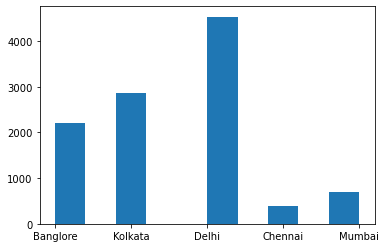

In [13]:
plt.hist(df.Source)

(array([ 932.,    0., 2871.,    0., 4536.,    0.,  381.,    0., 1265.,
         697.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

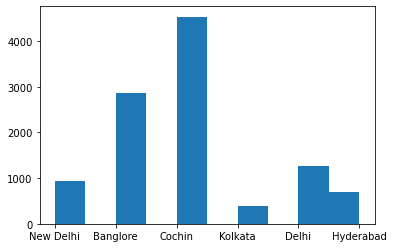

In [14]:
plt.hist(df.Destination)

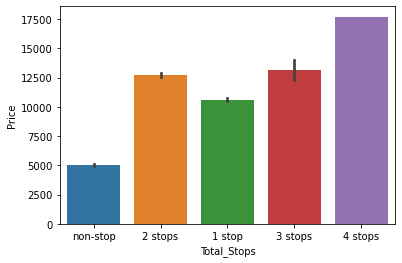

In [15]:
sns.barplot(df['Total_Stops'],df['Price'], data=df)

Assumptions from the EDA that's shown is that;
1. Delhi has the highest number of airplanes leaving the city
2. Cochin has a lot of visiting airplanes, can we say, a lot of tourists? visitors??
3. A 4-stop flight tends to be expensive

# Feature Engineering

In [16]:
#we can actually get the difference between the departed time and arrival time in minutes. That would be the duration taken
df['diff_durations']=df['Arrival_Time']-df['Dep_Time']
df['diff_durations']=df['diff_durations'].dt.total_seconds()/60

In [17]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional Info,Price,diff_durations
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2022-02-02 22:20:00,2022-03-22 01:10:00,non-stop,No info,3898,67850.0
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-02-02 05:50:00,2022-02-02 13:15:00,2 stops,No info,7663,445.0
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-02-02 09:25:00,2022-06-10 04:25:00,2 stops,No info,13883,184020.0
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-02-02 18:05:00,2022-02-02 23:30:00,1 stop,No info,6219,325.0
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2022-02-02 16:50:00,2022-02-02 21:35:00,1 stop,No info,13303,285.0


In [18]:
df.describe()

,Price,diff_durations
count,10682.000000,10682.000000
mean,9088.214567,55087.622636
std,4611.548810,74065.132177
min,1760.000000,-255.000000
25%,5278.000000,180.000000
50%,8373.000000,685.000000
75%,12374.000000,138805.000000
max,79513.000000,211080.000000


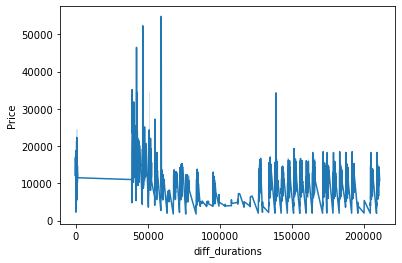

In [19]:
#relationship between minutes and price
sns.lineplot(x=df.diff_durations,y=df.Price, data=df)

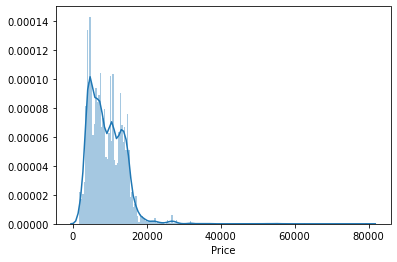

In [20]:
sns.distplot(df['Price'],kde=True, bins=200)

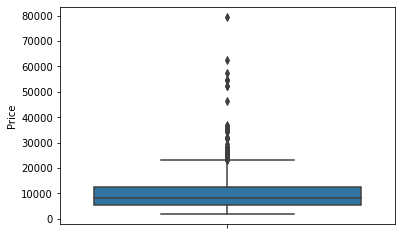

In [21]:
sns.boxplot(df['Price'],orient='vertical')

Woah, we can see that, our Price is rightly skewed, there are outliers outside the maximum whisker. Let use log transformation.
NOTE; A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. 
A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. 
A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [22]:
df['Price'].skew()

1.812404554693161

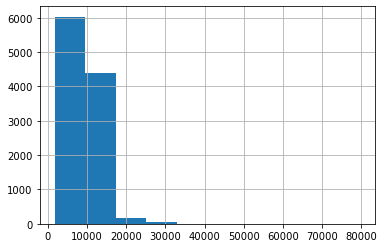

In [23]:
df['Price'].hist()

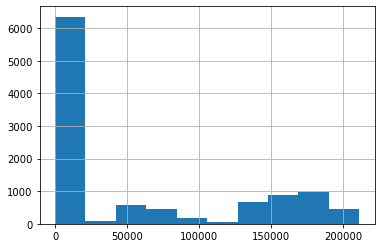

In [24]:
df['diff_durations'].hist()

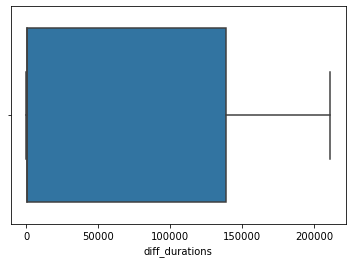

In [25]:
sns.boxplot(df['diff_durations'])

In [26]:
df['norm_diff_duration']=np.log(df['diff_durations']+1)

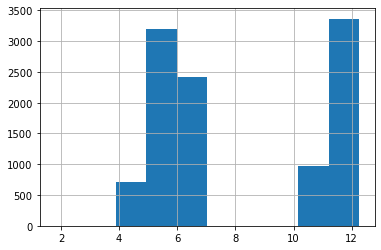

In [27]:
df['norm_diff_duration'].hist()

In [28]:
df['diff_durations'].skew()

0.8541091032270022

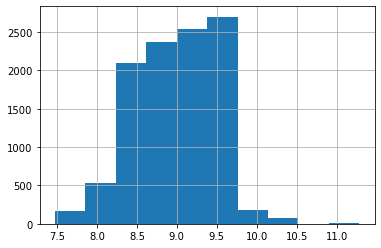

In [29]:
df['norm_Price']=np.log(df['Price']+1)
df['norm_Price'].hist()

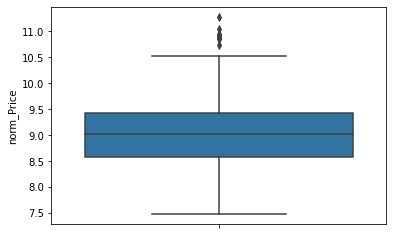

In [30]:
sns.boxplot(df['norm_Price'], orient='vertical')

In [31]:
df['norm_Price'].skew()

-0.2544199015014363

From the histogram and boxplot, we can see the skewness of our data dropped so low.

In [32]:
df['norm_Price']

0        8.268475
1        8.944289
2        9.538492
3        8.735525
4        9.495820
           ...   
10678    8.320935
10679    8.330140
10680    8.886133
10681    9.445412
10682    9.372034
Name: norm_Price, Length: 10682, dtype: float64

# Picking of columns for our model building

In [33]:
#we have to rename the column as it gives error when you want to pick the column cos of the space
df.rename(columns={'Additional Info': 'Additional_Info'}, inplace=True)

In [34]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,diff_durations,norm_diff_duration,norm_Price
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2022-02-02 22:20:00,2022-03-22 01:10:00,non-stop,No info,3898,67850.0,11.125069,8.268475
1,Air India,2019-01-05,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-02-02 05:50:00,2022-02-02 13:15:00,2 stops,No info,7663,445.0,6.100319,8.944289
2,Jet Airways,2019-09-06,Delhi,Cochin,DEL → LKO → BOM → COK,2022-02-02 09:25:00,2022-06-10 04:25:00,2 stops,No info,13883,184020.0,12.122805,9.538492
3,IndiGo,2019-12-05,Kolkata,Banglore,CCU → NAG → BLR,2022-02-02 18:05:00,2022-02-02 23:30:00,1 stop,No info,6219,325.0,5.786897,8.735525
4,IndiGo,2019-01-03,Banglore,New Delhi,BLR → NAG → DEL,2022-02-02 16:50:00,2022-02-02 21:35:00,1 stop,No info,13303,285.0,5.655992,9.495820


In [35]:
df.drop(df[['Date_of_Journey','Route', 'Additional_Info','Price','norm_diff_duration']],axis=1, inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Airline         10682 non-null  object        
 1   Source          10682 non-null  object        
 2   Destination     10682 non-null  object        
 3   Dep_Time        10682 non-null  datetime64[ns]
 4   Arrival_Time    10682 non-null  datetime64[ns]
 5   Total_Stops     10682 non-null  object        
 6   diff_durations  10682 non-null  float64       
 7   norm_Price      10682 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 751.1+ KB


In [37]:
df=pd.get_dummies(df,drop_first=True)

In [38]:
df.head()

,Dep_Time,Arrival_Time,diff_durations,norm_Price,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Total_Stops_2 stops,Total_Stops_3 stops,Total_Stops_4 stops,Total_Stops_non-stop
0,2022-02-02 22:20:00,2022-03-22 01:10:00,67850.0,8.268475,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,2022-02-02 05:50:00,2022-02-02 13:15:00,445.0,8.944289,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2022-02-02 09:25:00,2022-06-10 04:25:00,184020.0,9.538492,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,2022-02-02 18:05:00,2022-02-02 23:30:00,325.0,8.735525,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-02-02 16:50:00,2022-02-02 21:35:00,285.0,9.495820,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Rearranging the columns so that our target variable would be at the last.

In [39]:
df.columns.values

array(['Dep_Time', 'Arrival_Time', 'diff_durations', 'norm_Price',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara',
       'Airline_Vistara Premium economy', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Total_Stops_2 stops', 'Total_Stops_3 stops',
       'Total_Stops_4 stops', 'Total_Stops_non-stop'], dtype=object)

In [40]:
cols= ['Dep_Time', 'Arrival_Time', 'diff_durations',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara',
       'Airline_Vistara Premium economy', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Total_Stops_2 stops', 'Total_Stops_3 stops',
       'Total_Stops_4 stops', 'Total_Stops_non-stop','norm_Price']

In [41]:
df=df[cols]

In [44]:
df.head()

,diff_durations,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,...,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Total_Stops_2 stops,Total_Stops_3 stops,Total_Stops_4 stops,Total_Stops_non-stop,norm_Price
0,67850.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,8.268475
1,445.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,8.944289
2,184020.0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,9.538492
3,325.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.735525
4,285.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,9.495820


In [43]:
#Arrival_time and Dep_Time are supposed to be dropped since we have done feature engineering and got the difference in minutes
df.drop(df[['Dep_Time','Arrival_Time']],axis=1, inplace=True)

In [46]:
x=df.drop(['norm_Price'],axis=1)
y=df['norm_Price']

In [47]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=1/3, random_state=0)

In [52]:
mean_pred = np.repeat(ytrain.mean(),len(ytest))

sqrt(mean_squared_error(ytest, mean_pred))

0.5131933590543046

In [68]:
reg=LinearRegression()
reg.fit(xtrain,ytrain)

LinearRegression()

In [70]:
y_hat=reg.predict(xtrain)

Text(0.5, 1.0, 'Predicted vs Target')

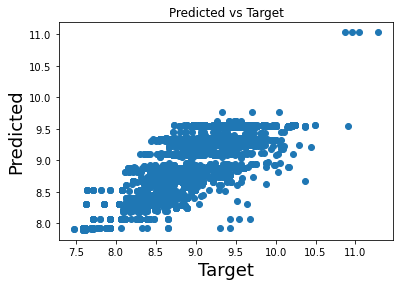

In [74]:
plt.scatter(ytrain,y_hat)
plt.xlabel('Target', size=18)
plt.ylabel('Predicted', size=18)
plt.title('Predicted vs Target')

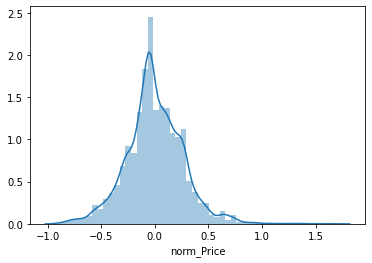

In [76]:
sns.distplot(ytrain-y_hat)

The graph shows we have our outliers tend to the right, which is going to affect our predictions on large prices

In [77]:
reg.score(xtrain,ytrain)

0.7249874075059306

In [78]:
reg.coef_

array([-1.57069539e-07,  2.75878153e-01, -1.17298484e-02,  4.80930225e-02,
        5.10777104e-01,  1.98879555e+00,  4.07109795e-01,  5.02065996e-01,
       -9.64489240e-02, -1.27806864e-01,  3.19550327e-01,  5.75053950e-01,
       -1.67675648e-02,  9.97049183e-03,  2.29538314e-02, -1.78222393e-01,
        9.97049183e-03, -7.18259509e-02, -1.78222393e-01, -1.67675648e-02,
        2.33891585e-01,  2.14904732e-01,  3.09334160e-01,  0.00000000e+00,
       -4.34227220e-01])

In [79]:
reg.intercept_

8.813216320414647

In [80]:
reg_summary=pd.DataFrame(x.columns.values, columns=['Features'])
reg_summary['weights']=reg.coef_
reg_summary

,Features,weights
0,diff_durations,-1.570695e-07
1,Airline_Air India,2.758782e-01
2,Airline_GoAir,-1.172985e-02
3,Airline_IndiGo,4.809302e-02
4,Airline_Jet Airways,5.107771e-01
5,Airline_Jet Airways Business,1.988796e+00
6,Airline_Multiple carriers,4.071098e-01
7,Airline_Multiple carriers Premium economy,5.020660e-01
8,Airline_SpiceJet,-9.644892e-02
9,Airline_Trujet,-1.278069e-01


# Testing

In [82]:
y_hat_test=reg.predict(xtest)

Text(0.5, 1.0, 'Predicted vs Target')

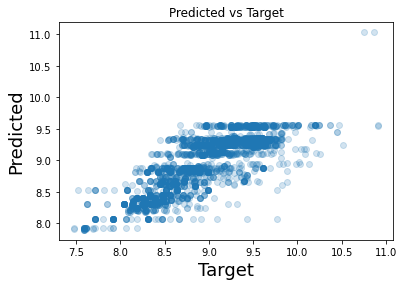

In [84]:
plt.scatter(ytest,y_hat_test, alpha=0.2)
plt.xlabel('Target', size=18)
plt.ylabel('Predicted', size=18)
plt.title('Predicted vs Target')

In [86]:
df_performance=pd.DataFrame(np.exp(y_hat_test), columns=['Predictions'])
df_performance.head()

,Predictions
0,11462.855729
1,7195.426175
2,3823.735325
3,14155.252422
4,4675.127009


In [87]:
ytest=ytest.reset_index(drop=True)
ytest

0       9.601233
1       8.637285
2       8.188411
3       9.726691
4       8.477620
          ...   
3556    9.088286
3557    8.989444
3558    9.450852
3559    9.514658
3560    9.078978
Name: norm_Price, Length: 3561, dtype: float64

In [88]:
df_performance['Targets']=np.exp(ytest)
df_performance

,Predictions,Targets
0,11462.855729,14783.0
1,7195.426175,5638.0
2,3823.735325,3599.0
3,14155.252422,16759.0
4,4675.127009,4806.0
...,...,...
3556,11313.187465,8851.0
3557,6754.163019,8018.0
3558,10302.819318,12719.0
3559,14023.677929,13557.0


In [91]:
df_performance['differences']=np.abs(df_performance['Predictions']-df_performance['Targets'])
df_performance

,Predictions,Targets,differences
0,11462.855729,14783.0,3320.144271
1,7195.426175,5638.0,1557.426175
2,3823.735325,3599.0,224.735325
3,14155.252422,16759.0,2603.747578
4,4675.127009,4806.0,130.872991
...,...,...,...
3556,11313.187465,8851.0,2462.187465
3557,6754.163019,8018.0,1263.836981
3558,10302.819318,12719.0,2416.180682
3559,14023.677929,13557.0,466.677929


In [92]:
df_performance['Percentage_difference']=(df_performance['differences']/df_performance['Targets'])*100
df_performance

,Predictions,Targets,differences,Percentage_difference
0,11462.855729,14783.0,3320.144271,22.459205
1,7195.426175,5638.0,1557.426175,27.623735
2,3823.735325,3599.0,224.735325,6.244382
3,14155.252422,16759.0,2603.747578,15.536414
4,4675.127009,4806.0,130.872991,2.723117
...,...,...,...,...
3556,11313.187465,8851.0,2462.187465,27.818184
3557,6754.163019,8018.0,1263.836981,15.762497
3558,10302.819318,12719.0,2416.180682,18.996625
3559,14023.677929,13557.0,466.677929,3.442339


In [94]:
df_performance.describe()

,Predictions,Targets,differences,Percentage_difference
count,3561.000000,3561.000000,3561.000000,3561.000000
mean,8740.201300,9098.464757,1970.383621,21.401832
std,3501.585414,4647.535935,2401.670137,20.056164
min,2681.049699,1761.000000,0.585125,0.006654
25%,5731.366383,5230.000000,525.745899,7.003797
50%,9360.400977,8368.000000,1231.738409,15.870087
75%,11192.830364,12375.000000,2834.326324,29.326599
max,61711.145400,54828.000000,40803.595164,175.853589


In [96]:
pd.options.display.max_rows=999
pd.set_option('display.float_format', lambda x:'%.2f' % x)
df_performance.sort_values(by=['Percentage_difference'])

,Predictions,Targets,differences,Percentage_difference
2211,8794.59,8794.00,0.59,0.01
2353,11000.14,10993.00,7.14,0.06
3490,3632.11,3627.00,5.11,0.14
540,7195.36,7207.00,11.64,0.16
1055,11011.82,10993.00,18.82,0.17
...,...,...,...,...
2074,5081.23,2230.00,2851.23,127.86
2569,11082.67,4649.00,6433.67,138.39
1636,14155.01,5855.00,8300.01,141.76
2272,5081.22,2073.00,3008.22,145.11
